## Importing the goodies 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Importing the goodies and defining some paths 


In [ ]:
import torch
import torchvision
import torch.nn as nn                                                
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
from IPython.display import clear_output
from torchvision.transforms import ToTensor
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from torch.optim.lr_scheduler import ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler
import cv2
import time
from tqdm.notebook import tqdm
import torchvision.datasets as datasets
import os
from numpy import moveaxis
import pandas as pd
import random


# numpy image: H x W x C
# torch image: C X H X W

In [25]:
!cp  /content/drive/"My Drive"/mind_the_bend/ensemble_frames_46k.tar.xz /content/ 
!tar -xf /content/ensemble_frames_46k.tar.xz -C /content/

In [26]:
!cp  /content/drive/"My Drive"/mind_the_bend/training_data.csv /content/ 

In [27]:
df = pd.read_csv("training_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23327 entries, 0 to 23326
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  23327 non-null  int64 
 1   upper       23327 non-null  object
 2   lower       23327 non-null  object
 3   steer       23327 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 729.1+ KB


## Custom DataLoader class whic would be compatible with image folders and CSV files 


In [42]:
class MyDataset(Dataset):
    '''
    Build your own dataset
    '''
    def __init__(self, csv_file_path , transform = None, steering_noise = False):

        self.main_df = pd.read_csv(csv_file_path)
        self.upper_paths = self.main_df["upper"].values
        self.lower_paths = self.main_df["lower"].values
        self.labels = self.main_df["steer"].values
        self.steering_noise = steering_noise 
        self.transform = transform 


    def __getitem__(self, item):

        upper = cv2.imread(self.upper_paths[item],0)
        lower = cv2.imread(self.lower_paths[item])
        lower = cv2.cvtColor(lower, cv2.COLOR_BGR2RGB)
        label = self.labels[item]

  

        if self.steering_noise == True:
            label = label + random.randint(-5,5)
        
        if self.transform is not None:
            upper = self.transform(upper)
            lower = self.transform(lower)



        return (upper, lower), torch.tensor([label])

    def __len__(self):
        return len(self.labels)

In [43]:
full_dataset = MyDataset("training_data.csv",  
                      steering_noise = True,
                      transform =transforms.Compose([          
                                                transforms.ToPILImage(),
                                                torchvision.transforms.RandomAffine(degrees = 5, translate= (0, 0), scale=None, shear=None, resample=False, fillcolor=0),
                                                ToTensor()
                                                ])
              )


## Loading up the training data in a batches

In [44]:
train_size = int(0.8* len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 4, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")
sample = next(iter(train_loader))

1167 batches 
1167  batches 


## Viewing some samples from training data 

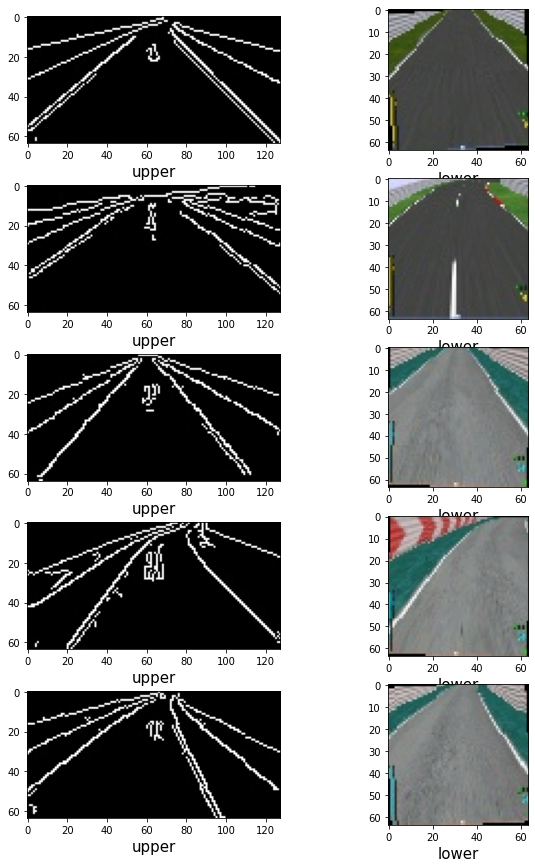

In [47]:
(upper,lower), labels = sample

fig, ax = plt.subplots(5,2, figsize = (10,15))
c = 0
for i in range (5):
    for j in range (2):
    
        upper_im = upper[i][0]
        lower_im = np.moveaxis(lower[i].numpy(), 0,2)

        ax[i][0].imshow(upper_im, cmap = "gray")
        ax[i][1].imshow(lower_im)
        ax[i][0].set_xlabel('upper', fontsize = 15)
        ax[i][1].set_xlabel('lower', fontsize = 15)



## Utils for metrics collection

In [48]:
def vis_loss_multi(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=7)
    plt.plot( ysmoothed, label = "training loss")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=18)
    plt.plot(ysmoothed2, label = "validation loss")
    plt.show()

def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize = 15)                                       
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()     

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def show_deltas(deltas):
    deltas = gaussian_filter1d(deltas, sigma=3)
    plt.plot(deltas, "r", label = "Absolute error from label ")
    plt.ylabel("Error", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def show_acc(deltas):
    deltas = gaussian_filter1d(deltas, sigma=3)
    plt.plot(deltas, "r", label = "Accuracy")
    plt.ylabel("Acc ", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

## Training loop

In [49]:

def train_step(x, y, model, optimizer, criterion):
        optimizer.zero_grad()
        pred = model(x)
        y = y.float()
        loss = criterion(pred,y)
        loss.backward()
        optimizer.step()
        return loss.item()


def train_model(config):

    epochs = config["epochs"]
    model = config["model"]
    train_loder = config["train_loader"]
    val_loader = config["val_loader"]
    optimizer = config["optimizer"]
    scheduler = config["scheduler"]
    criterion = config["loss_function"]

    start = time.process_time()
    losses = []
    val_losses = []
    learning_rates = []
    average_deltas = []

    for m in range (epochs):
        clear_output(wait = True)
        vis_loss_multi_colors(losses, val_losses)
        show_lr(learning_rates)
        show_deltas(average_deltas)
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            model.eval()

            for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):

                yhat =model(x_val)  # pred 
                val_loss = criterion(yhat.cuda(), y_val.cuda())
                val_losses.append(val_loss.item())  ## metrics 

                average_deltas.append(torch.mean(torch.abs(yhat.cpu()-y_val.cpu())).item())


        model.train()
       
        for batch in tqdm(train_loader, desc = " Training batches : "):
           
            (x_batch, y_batch) = batch

            loss = train_step(x_batch, y_batch.cuda(), model, optimizer, criterion)
            losses.append(loss)
        scheduler.step(1.)   ## lr decay caller 
        learning_rates.append(get_lr(optimizer))
        

    clear_output(wait = True)

    vis_loss_multi_colors(losses, val_losses)
    show_lr(learning_rates)
    show_deltas(average_deltas)

    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses


## The CNN

In [50]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.upper_conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        self.upper_conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.upper_conv3 = nn.Conv2d(32, 32, 3, padding = 1)

        self.pool = nn.MaxPool2d(3, 3)
        
        self.upper_fc1 = nn.Linear(256,128)
        self.upper_fc2 = nn.Linear(128, 64)

################################################################# had to do this 

        self.lower_conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.lower_conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.lower_conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        
        self.lower_fc1 = nn.Linear(256,128)
        self.lower_fc2 = nn.Linear(128, 64)

        ## meet and greet at at 64, 64, concat to 128 

        self.combined_fc1 = nn.Linear(128, 128)
        self.combined_fc2 = nn.Linear(128, 64)
        self.combined_fc3 = nn.Linear(64, 1)


    def forward(self, x, cuda = True):

        (upper, lower)  = x   ## unpack 

        if cuda == True:
            upper = upper.cuda()
            lower = lower.cuda()

        x_upper = self.pool(F.relu(self.upper_conv1(upper)))
        x_upper = self.pool(F.relu(self.upper_conv2(x_upper)))
        x_upper = self.pool(F.relu(self.upper_conv3(x_upper)))

        x_upper = x_upper.view(x_upper.size(0), -1)
        x_upper = F.relu(self.upper_fc1(x_upper))
        x_upper = F.relu(self.upper_fc2(x_upper))

################################# one more border, please dont mess this part up 

        x_lower = self.pool(F.relu(self.lower_conv1(lower)))
        x_lower = self.pool(F.relu(self.lower_conv2(x_lower)))
        x_lower = self.pool(F.relu(self.lower_conv3(x_lower)))

        x_lower = x_lower.view(x_lower.size(0), -1)
        x_lower = F.relu(self.lower_fc1(x_lower))
        x_lower = F.relu(self.lower_fc2(x_lower))
    
        x = torch.cat((x_upper ,x_lower), dim=1)

        x = F.relu(self.combined_fc1(x))
        x = F.relu(self.combined_fc2(x))
        x = self.combined_fc3(x)


        return x

drunk_driver = Net()
drunk_driver = drunk_driver.cuda()
print(drunk_driver)
optimizer = optim.Adam(drunk_driver.parameters(), lr = 0.003) 

scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.5, 
                                patience=5, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0, 
                                eps=1e-08)


Net(
  (upper_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upper_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upper_conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (upper_fc1): Linear(in_features=256, out_features=128, bias=True)
  (upper_fc2): Linear(in_features=128, out_features=64, bias=True)
  (lower_conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lower_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lower_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lower_fc1): Linear(in_features=256, out_features=128, bias=True)
  (lower_fc2): Linear(in_features=128, out_features=64, bias=True)
  (combined_fc1): Linear(in_features=128, out_features=128, bias=True)
  (combined_fc2): Linear(in_features=128, out_features=64, bias=True)
  (

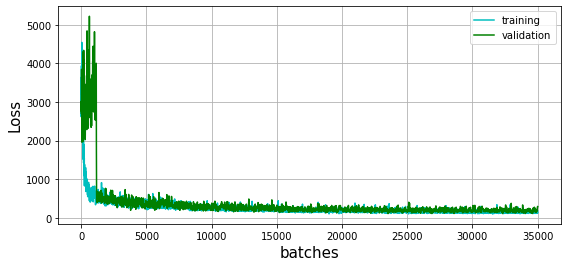

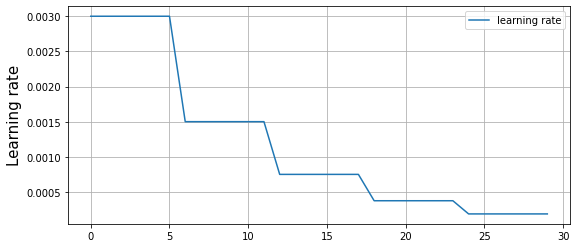

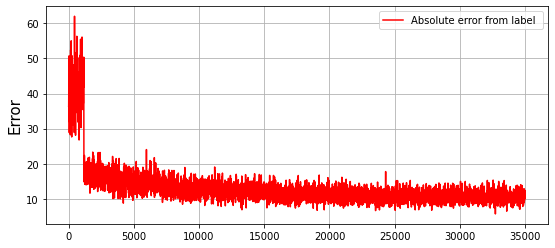

Time elapsed =  1637.314335232  seconds


In [51]:
plt.rcParams["figure.figsize"] = (9,4)

config = { 
        "epochs" : 30,    
        "model" : drunk_driver,      
        "train_loader" : train_loader, 
        "val_loader" : val_loader,
        "optimizer" : optimizer,
        "scheduler" : scheduler,
        "loss_function" : nn.MSELoss()
        }
losses = train_model(config)


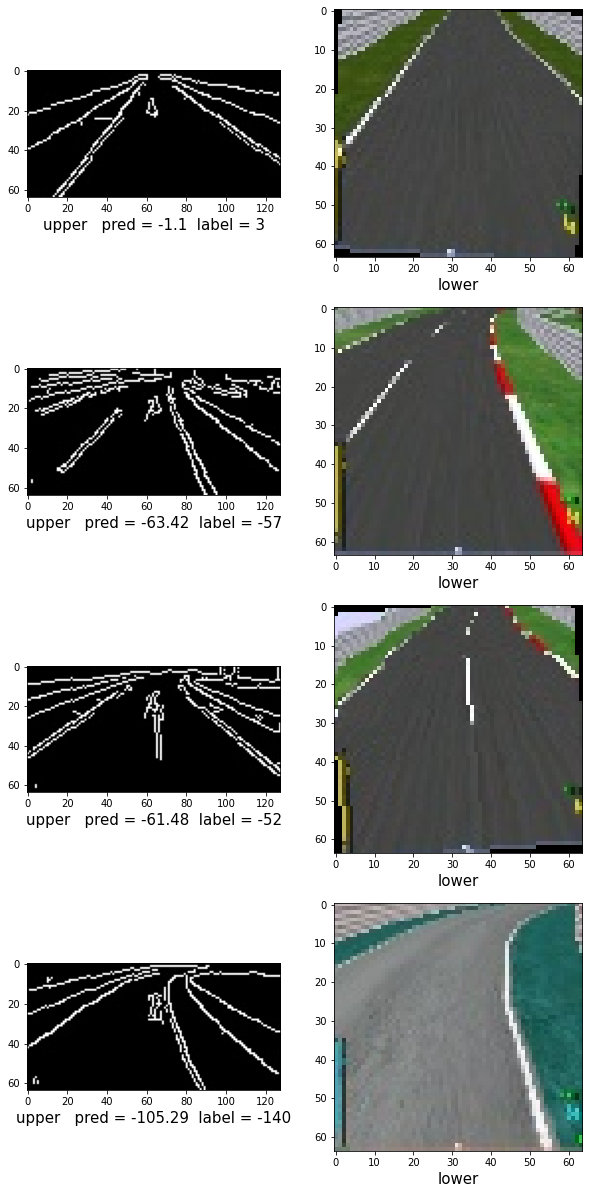

In [54]:
(upper,lower), labels = next(iter(val_loader))

preds = drunk_driver((upper,lower))


fig, ax = plt.subplots(4,2, figsize = (10,21))
c = 0
for i in range (4):
    for j in range (2):
        label = labels[i].item()
        pred = round(preds[i].detach().item(),2)
        
    
        upper_im = upper[i][0]
        lower_im = np.moveaxis(lower[i].numpy(), 0,2)

        ax[i][0].imshow(upper_im, cmap = "gray")
        ax[i][1].imshow(lower_im)
        ax[i][0].set_xlabel('upper   pred = '+ str(pred) + "  label = " + str(label), fontsize = 15)
        ax[i][1].set_xlabel('lower', fontsize = 15)



In [56]:
# !mkdir torch
torch.save(drunk_driver.state_dict(), "torch/drunk_driver_ensemble_2.pt")